<a href="https://colab.research.google.com/github/pawelszajwaj/Segregation/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pobranie z githuba plików audio

In [1]:
!git clone https://github.com/pawelszajwaj/Segregation.git

Cloning into 'Segregation'...
remote: Enumerating objects: 562, done.
remote: Counting objects: 100% (167/167), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 562 (delta 50), reused 102 (delta 27), pack-reused 395
Receiving objects: 100% (562/562), 821.93 MiB | 29.72 MiB/s, done.
Resolving deltas: 100% (122/122), done.
Updating files: 100% (79/79), done.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from glob import glob

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle

sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [3]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers

In [4]:
!pip install tensorflow-io
import tensorflow_io as tfio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.8/28.8 MB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 85.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.33.0
    Uninstalling tensorflow-io-gcs-filesystem-0.33.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.33.0


In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout

In [6]:
!mkdir AudioFiles
!mkdir AudioFiles/Good
!mkdir AudioFiles/Bad

In [7]:
!unzip '/content/Segregation/AudioFiles/5seconds/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/5seconds/Bad/*.zip' -d '/content/AudioFiles/Bad'

#if os.path.exists("/content/AudioFiles/Bad/13.1.21.wav"):
#  os.remove("/content/AudioFiles/Bad/13.1.21.wav")



Archive:  /content/Segregation/AudioFiles/5seconds/Good/5_seconds_1-5.zip
  inflating: /content/AudioFiles/Good/5.1.12.wav  
  inflating: /content/AudioFiles/Good/1.1.1.wav  
  inflating: /content/AudioFiles/Good/1.1.2.wav  
  inflating: /content/AudioFiles/Good/1.1.3.wav  
  inflating: /content/AudioFiles/Good/1.1.4.wav  
  inflating: /content/AudioFiles/Good/1.1.5.wav  
  inflating: /content/AudioFiles/Good/1.1.6.wav  
  inflating: /content/AudioFiles/Good/1.1.7.wav  
  inflating: /content/AudioFiles/Good/1.1.8.wav  
  inflating: /content/AudioFiles/Good/1.1.9.wav  
  inflating: /content/AudioFiles/Good/1.1.10.wav  
  inflating: /content/AudioFiles/Good/1.1.11.wav  
  inflating: /content/AudioFiles/Good/1.1.12.wav  
  inflating: /content/AudioFiles/Good/2.1.1.wav  
  inflating: /content/AudioFiles/Good/2.1.2.wav  
  inflating: /content/AudioFiles/Good/2.1.3.wav  
  inflating: /content/AudioFiles/Good/2.1.4.wav  
  inflating: /content/AudioFiles/Good/2.1.5.wav  
  inflating: /content/

In [8]:
audio_files = glob('/content/AudioFiles/*/*.wav')
audio_files_good = glob('/content/AudioFiles/Good/*.wav')
audio_files_bad = glob('/content/AudioFiles/Bad/*.wav')

In [9]:
def load_wav_16k_mono(filename):
  file_contents = tf.io.read_file(filename)
  wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
  wav = tf.squeeze(wav, axis=-1)
  sample_rate = tf.cast(sample_rate, dtype = tf.int64)
  wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
  return wav

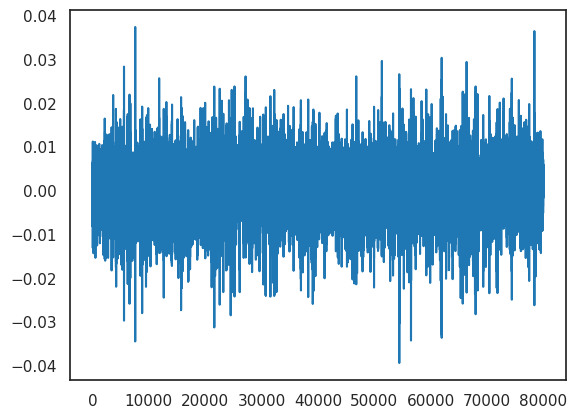

In [10]:
wav = load_wav_16k_mono(audio_files_bad[0])
wav = load_wav_16k_mono(audio_files_good[0])
plt.plot(wav.numpy())

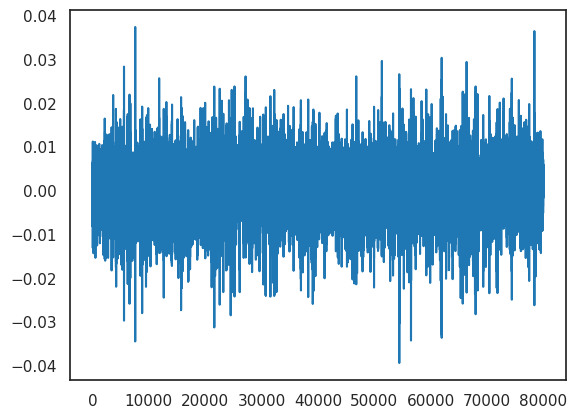

In [11]:
wav = tf.cast(wav, tf.float32)
plt.figure()
plt.plot(wav.numpy())

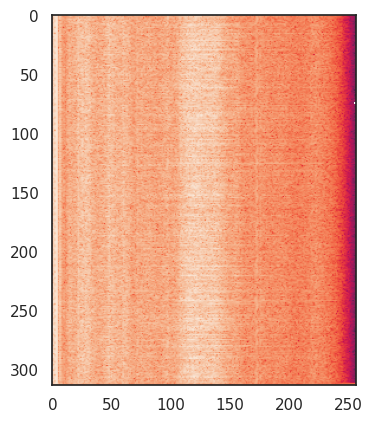

In [12]:
spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
plt.figure()
plt.imshow(tf.math.log(spectrogram).numpy())

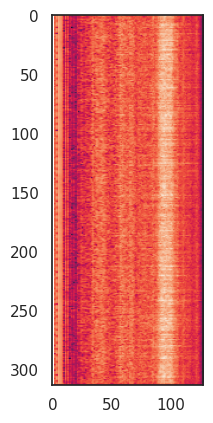

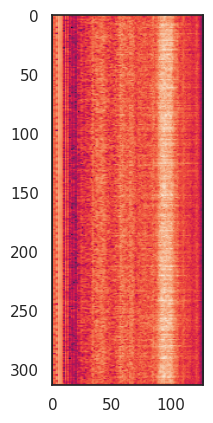

In [13]:
mel_spectrogram = tfio.audio.melscale(
  spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
dbscale_mel_spectrogram = tfio.audio.dbscale(
  mel_spectrogram, top_db=80)

plt.figure()
plt.imshow(tf.math.log(mel_spectrogram).numpy())

plt.figure()
plt.imshow(dbscale_mel_spectrogram.numpy())

In [14]:
good = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.wav')
bad = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/2.1.8.wav'

In [15]:
positives = tf.data.Dataset.zip((good, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((bad, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Bad/14.1.6.wav', 0.0)

In [ ]:
positives = tf.data.Dataset.zip((goodZ, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodZ)))))
negatives = tf.data.Dataset.zip((badZ, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badZ)))))
data = positives.concatenate(negatives)
data.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFiles/Bad/14.12.Z.wav', 0.0)

In [16]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [18]:
print(len(data))
train = data.take(10)
test = data.skip(10).take(6)

16


In [19]:
print(len(data))
train = data.take(12)
test = data.skip(12).take(5)

16


In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 313, 128, 1)

In [22]:
labels

array([0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

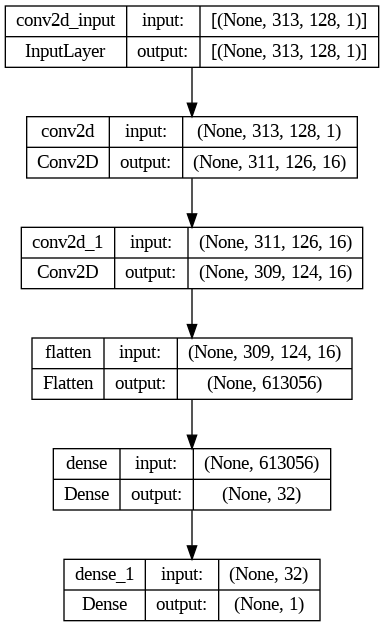

In [24]:
model.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 311, 126, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 309, 124, 16)      2320      
                                                                 
 flatten (Flatten)           (None, 613056)            0         
                                                                 
 dense (Dense)               (None, 32)                19617824  
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19620337 (74.85 MB)
Trainable params: 19620337 (74.85 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
hist = model.fit(train, epochs=3, validation_data=test)

Epoch 1/3
12/12 [==============================] - 25s 2s/step - loss: 250.0192 - recall: 0.5957 - precision: 0.5773 - val_loss: 17.5021 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/3
12/12 [==============================] - 11s 963ms/step - loss: 7.0891 - recall: 0.4839 - precision: 0.4787 - val_loss: 0.6912 - val_recall: 1.0000 - val_precision: 0.4717
Epoch 3/3
12/12 [==============================] - 12s 977ms/step - loss: 3.4156 - recall: 0.8247 - precision: 0.5063 - val_loss: 0.6926 - val_recall: 1.0000 - val_precision: 0.5556


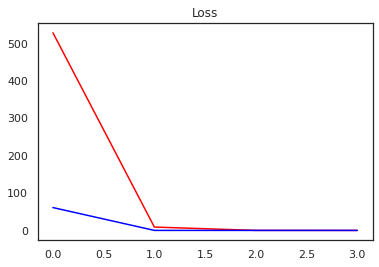

In [ ]:
plt.title("Loss")
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'],'b')
plt.show()

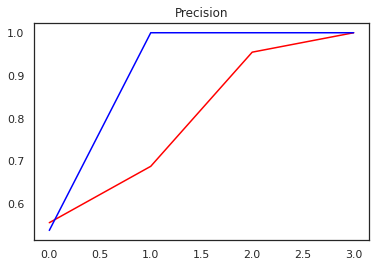

In [ ]:
plt.title("Precision")
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'],'b')
plt.show()

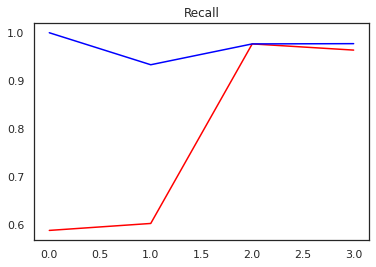

In [ ]:
plt.title("Recall")
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'],'b')
plt.show()

In [ ]:
# WIELKI TEST
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 314ms/step


In [ ]:
yhat

array([[1.1610431e-11],
       [2.7547368e-28],
       [2.6993445e-20],
       [9.9999994e-01],
       [2.5753836e-05],
       [1.2312714e-35],
       [3.3550328e-01],
       [0.0000000e+00],
       [9.9880159e-01],
       [9.9931055e-01],
       [1.0000000e+00],
       [9.9993289e-01],
       [9.9999875e-01],
       [9.9994427e-01],
       [9.9999976e-01],
       [9.9999309e-01]], dtype=float32)

In [ ]:
y_test  ## ewidentnie przetretnowany

array([0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.],
      dtype=float32)

In [ ]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)
print(np.hstack(yhat))
print(y_test)     # troche beznadziejnie  - czyzby z=samym audio sie nei dalo?


[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
[1 0 0 0 0 1 0 0 1 1 0 1 0 1 1 1]


# Tu sprawdzimy, czy inny podział ma sens.

Podzielimy dane na 2 rodzaje danych:
 - pierwsza grupa to te ewidetnie złe vs reszta
 - druga to to srednie vs te dobre.

Podział zostanie przeprowadzony zgodnie z przyjetymi zalozeniami, tj. 1-10 dobre, 11-23 złe


In [27]:
!mkdir AudioFilesVar
!mkdir AudioFilesVar/Good
!mkdir AudioFilesVar/Bad
!mkdir AudioFilesVar/Mid
!mkdir AudioFilesVar/Good_and_Mid

In [28]:
!unzip '/content/Segregation/AudioFilesVar/5seconds/Good/*.zip' -d '/content/AudioFilesVar/Good'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Bad/*.zip' -d '/content/AudioFilesVar/Bad'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Mid/*.zip' -d '/content/AudioFilesVar/Mid'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Mid/*.zip' -d '/content/AudioFilesVar/Good_and_Mid'
!unzip '/content/Segregation/AudioFilesVar/5seconds/Good/*.zip' -d '/content/AudioFilesVar/Good_and_Mid'


if os.path.exists("/content/AudioFilesVar/Bad/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Bad/13.1.21 - bad file!.wav")
if os.path.exists("/content/AudioFilesVar/Mid/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Mid/13.1.21 - bad file!.wav")
if os.path.exists("/content/AudioFilesVar/Good_and_Mid/13.1.21 - bad file!.wav"):
  os.remove("/content/AudioFilesVar/Good_and_Mid/13.1.21 - bad file!.wav")

Archive:  /content/Segregation/AudioFilesVar/5seconds/Good/5_seconds_1-5.zip
  inflating: /content/AudioFilesVar/Good/5.1.12.wav  
  inflating: /content/AudioFilesVar/Good/1.1.1.wav  
  inflating: /content/AudioFilesVar/Good/1.1.2.wav  
  inflating: /content/AudioFilesVar/Good/1.1.3.wav  
  inflating: /content/AudioFilesVar/Good/1.1.4.wav  
  inflating: /content/AudioFilesVar/Good/1.1.5.wav  
  inflating: /content/AudioFilesVar/Good/1.1.6.wav  
  inflating: /content/AudioFilesVar/Good/1.1.7.wav  
  inflating: /content/AudioFilesVar/Good/1.1.8.wav  
  inflating: /content/AudioFilesVar/Good/1.1.9.wav  
  inflating: /content/AudioFilesVar/Good/1.1.10.wav  
  inflating: /content/AudioFilesVar/Good/1.1.11.wav  
  inflating: /content/AudioFilesVar/Good/1.1.12.wav  
  inflating: /content/AudioFilesVar/Good/2.1.1.wav  
  inflating: /content/AudioFilesVar/Good/2.1.2.wav  
  inflating: /content/AudioFilesVar/Good/2.1.3.wav  
  inflating: /content/AudioFilesVar/Good/2.1.4.wav  
  inflating: /cont

In [29]:
audio_files_var = glob('/content/AudioFilesVar/*/*.wav')
audio_files_var_good = glob('/content/AudioFilesVar/Good/*.wav')
audio_files_var_bad = glob('/content/AudioFilesVar/Bad/*.wav')
audio_files_var_mid = glob('/content/AudioFilesVar/Mid/*.wav')
audio_files_var_good_and_bad = glob('/content/AudioFilesVar/{Good,Mid}/*.wav')

In [30]:
goodmidvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Good_and_Mid/*.wav')
badvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Bad/*.wav')
goodvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Good/*.wav')
midvar = tf.data.Dataset.list_files('/content/AudioFilesVar/Mid/*.wav')
good.as_numpy_iterator().next()

b'/content/AudioFiles/Good/4.1.3.wav'

In [31]:
positives = tf.data.Dataset.zip((goodmidvar, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((badvar, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
datavar1 = positives.concatenate(negatives)
datavar1.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFilesVar/Good_and_Mid/1.1.5.wav', 1.0)

In [32]:
datavar1 = datavar1.map(preprocess)
datavar1 = datavar1.cache()
datavar1 = datavar1.shuffle(buffer_size=1000)
datavar1 = datavar1.batch(16)
datavar1 = datavar1.prefetch(8)

In [33]:
print(len(datavar1))
train = datavar1.take(8)
test = datavar1.skip(8).take(4)

12


In [34]:
modelvar1 = Sequential()
modelvar1.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelvar1.add(Conv2D(16, (3,3), activation='relu'))
modelvar1.add(Flatten())
modelvar1.add(Dense(128, activation='relu'))
modelvar1.add(Dense(1, activation='sigmoid'))

In [35]:
modelvar1.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 311, 126, 16)      160       
                                                                 
 conv2d_3 (Conv2D)           (None, 309, 124, 16)      2320      
                                                                 
 flatten_1 (Flatten)         (None, 613056)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               78471296  
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 78473905 (299.35 MB)
Trainable params: 78473905 (299.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


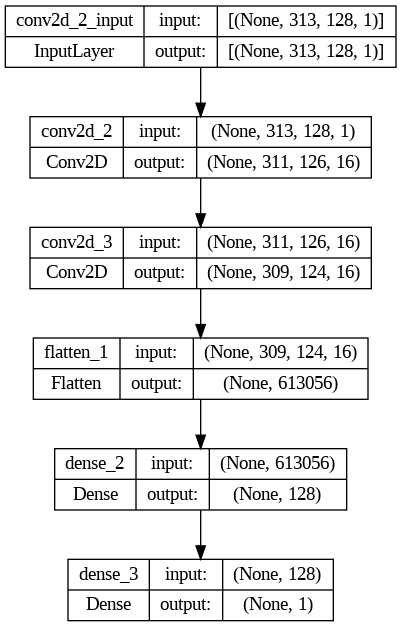

In [36]:
modelvar1.summary()
keras.utils.plot_model(modelvar1, "multi_input_and_output_model.png", show_shapes=True)

In [37]:
histvar1 = modelvar1.fit(train, epochs=6, validation_data=test)

Epoch 1/6
8/8 [==============================] - 24s 2s/step - loss: 513.6600 - recall_1: 0.6310 - precision_1: 0.7162 - val_loss: 115.5072 - val_recall_1: 1.0000 - val_precision_1: 0.7959
Epoch 2/6
8/8 [==============================] - 15s 2s/step - loss: 62.4392 - recall_1: 1.0000 - precision_1: 0.8252 - val_loss: 29.5542 - val_recall_1: 0.3514 - val_precision_1: 1.0000
Epoch 3/6
8/8 [==============================] - 15s 2s/step - loss: 12.1343 - recall_1: 0.8118 - precision_1: 0.9718 - val_loss: 2.5790 - val_recall_1: 0.9500 - val_precision_1: 1.0000
Epoch 4/6
8/8 [==============================] - 15s 2s/step - loss: 1.2907 - recall_1: 0.9524 - precision_1: 1.0000 - val_loss: 2.7304e-07 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 5/6
8/8 [==============================] - 15s 2s/step - loss: 6.3206e-04 - recall_1: 1.0000 - precision_1: 1.0000 - val_loss: 6.7267e-10 - val_recall_1: 1.0000 - val_precision_1: 1.0000
Epoch 6/6
8/8 [==============================] - 15s 2s/

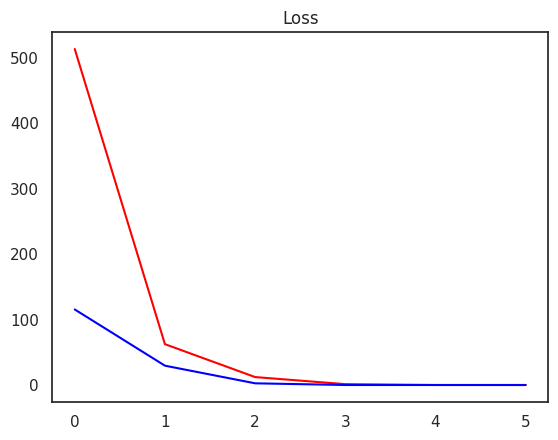

In [38]:
plt.title("Loss")
plt.plot(histvar1.history['loss'], 'r')
plt.plot(histvar1.history['val_loss'],'b')
plt.show()

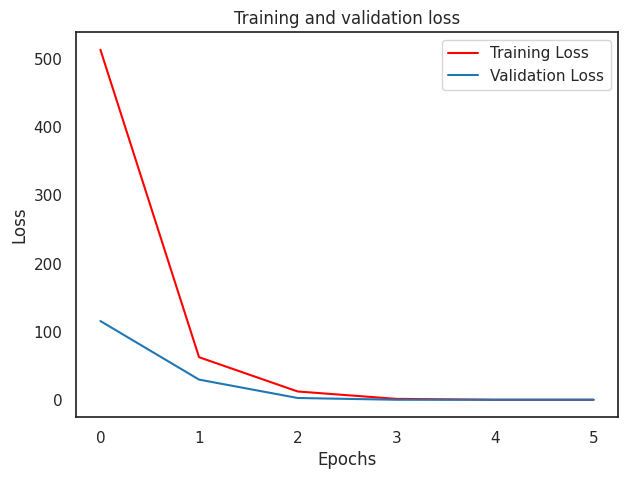

In [46]:
epochs=range(1,7)
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(histvar1.history['loss'],'r',label='Training Loss')
ax.plot(histvar1.history['val_loss'], label='Validation Loss')
ax.set_title('Training and validation loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()

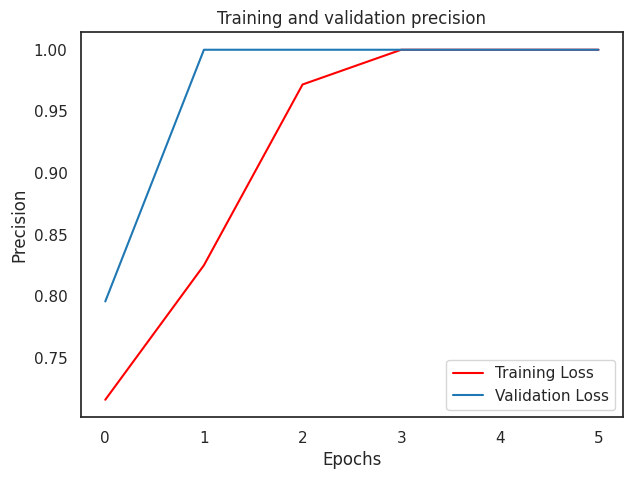

In [48]:
epochs=range(1,7)
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(histvar1.history['precision_1'],'r', label='Training Loss')
ax.plot(histvar1.history['val_precision_1'], label='Validation Loss')
ax.set_title('Training and validation precision')
ax.set_xlabel('Epochs')
ax.set_ylabel('Precision')
ax.legend()

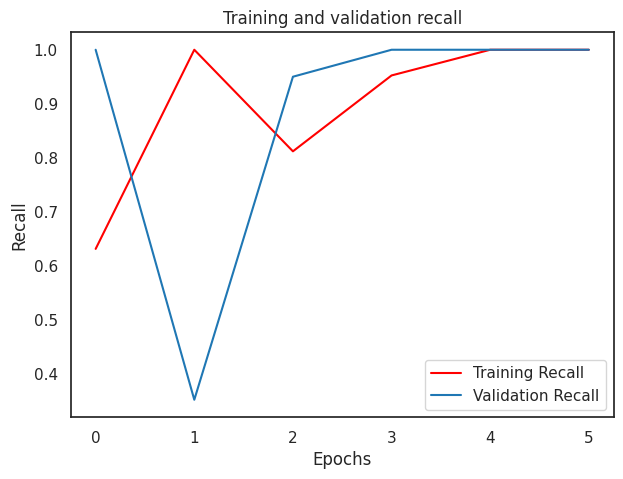

In [49]:
epochs=range(1,7)
fig, ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(histvar1.history['recall_1'],'r',label='Training Recall')
ax.plot(histvar1.history['val_recall_1'], label='Validation Recall')
ax.set_title('Training and validation recall')
ax.set_xlabel('Epochs')
ax.set_ylabel('Recall')
ax.legend()

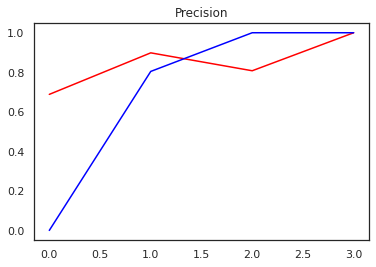

In [ ]:
plt.title("Precision")
plt.plot(histvar1.history['precision_3'], 'r')
plt.plot(histvar1.history['val_precision_3'],'b')
plt.show()

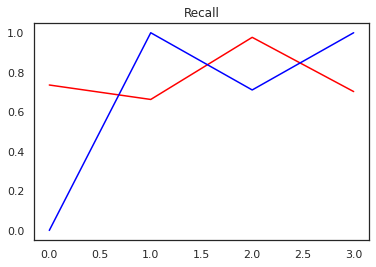

In [ ]:
plt.title("Recall")
plt.plot(histvar1.history['recall_3'], 'r')
plt.plot(histvar1.history['val_recall_3'],'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = modelvar1.predict(X_test)

1/1 [==============================] - 0s 358ms/step


In [ ]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)

In [ ]:
print(np.hstack(yhat))
print(y_test)

[0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1]
[0 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1]


# PIERWSZY PODZIAŁ WYADJE SIĘ SESOWNY. TERAZ, GDY ODRZUCILIŚMY JUŻ TE NA 100% ZŁE, CZAS NA LEKKO SUBTELNIJSZY PODZIAŁ, CZYLI NA GOOD VS MID

In [50]:
positives = tf.data.Dataset.zip((goodvar, tf.data.Dataset.from_tensor_slices(tf.ones(len(good)))))
negatives = tf.data.Dataset.zip((midvar, tf.data.Dataset.from_tensor_slices(tf.zeros(len(good)))))
datavar2 = positives.concatenate(negatives)
datavar2.shuffle(1000).as_numpy_iterator().next()

(b'/content/AudioFilesVar/Mid/17.1.4.wav', 0.0)

In [51]:
datavar2 = datavar2.map(preprocess)
datavar2 = datavar2.cache()
datavar2 = datavar2.shuffle(buffer_size=1000)
datavar2 = datavar2.batch(16)
datavar2 = datavar2.prefetch(8)

In [52]:
print(len(datavar2))
train = datavar2.take(10)
test = datavar2.skip(4).take(4)

14


In [53]:
from tensorflow.keras.constraints import MaxNorm

In [54]:
modelvar2 = Sequential()
modelvar2.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelvar2.add(Conv2D(16, (3,3), activation='relu'))
modelvar2.add(Dropout(0.2))
modelvar2.add(Flatten())
modelvar2.add(Dense(32, activation='relu', kernel_constraint=MaxNorm(1.)))
modelvar2.add(Dense(1, activation='sigmoid'))

In [55]:
modelvar2.compile("Adam", loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [56]:
modelvar2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 311, 126, 16)      160       
                                                                 
 conv2d_5 (Conv2D)           (None, 309, 124, 16)      2320      
                                                                 
 dropout (Dropout)           (None, 309, 124, 16)      0         
                                                                 
 flatten_2 (Flatten)         (None, 613056)            0         
                                                                 
 dense_4 (Dense)             (None, 32)                19617824  
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19620337 (74.85 MB)
Trainable params: 19

In [ ]:
histvar2 = modelvar2.fit(train, epochs=6, validation_data=test)

Epoch 1/6


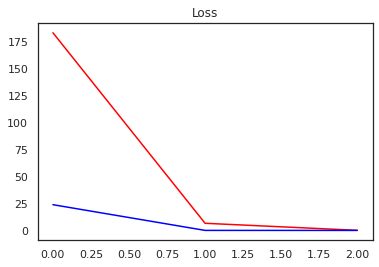

In [ ]:
plt.title("Loss")
plt.plot(histvar2.history['loss'], 'r')
plt.plot(histvar2.history['val_loss'],'b')
plt.show()

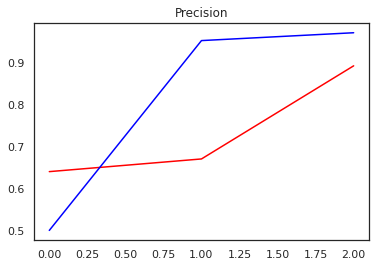

In [ ]:
plt.title("Precision")
plt.plot(histvar2.history['precision_5'], 'r')
plt.plot(histvar2.history['val_precision_5'],'b')
plt.show()

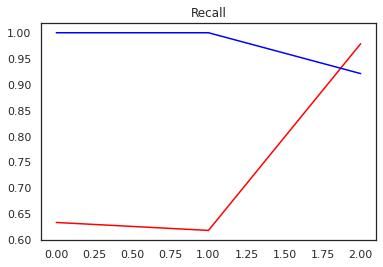

In [ ]:
plt.title("Recall")
plt.plot(histvar2.history['recall_5'], 'r')
plt.plot(histvar2.history['val_recall_5'],'b')
plt.show()

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

In [ ]:
yhat = modelvar2.predict(X_test)

1/1 [==============================] - 0s 339ms/step


In [ ]:
yhat = np.array(np.hstack(yhat), dtype=int)
y_test = np.array(np.hstack(y_test), dtype=int)

In [ ]:
print(np.hstack(yhat))
print(y_test)     # troche beznadziejnie  - czyzby z=samym audio sie nei dalo?
                  # dropout layer dodaje jakies 2/3 dobre trafienia
                  # po dodainu normalizaci =1 do dense layaer znowu nic nie dziala

[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
[1 0 0 0 1 0 1 0 1 0 1 0 0 0 1 1]


**CZAS NA 4-x input! tak, bedziemy dawac wsio -> audio + dragnia xyz.
Pytanie - czy potrzebujhemy wszystkie kierunki?t**

In [ ]:
!unzip '/content/Segregation/AudioFiles/5secondsvibro/Good/*.zip' -d '/content/AudioFiles/Good'
!unzip '/content/Segregation/AudioFiles/5secondsvibro/Bad/*.zip' -d '/content/AudioFiles/Bad'

Archive:  /content/Segregation/AudioFiles/5secondsvibro/Good/7.zip
  inflating: /content/AudioFiles/Good/7.11.Z.wav  
  inflating: /content/AudioFiles/Good/7.1.Audio.wav  
  inflating: /content/AudioFiles/Good/7.1.X.wav  
  inflating: /content/AudioFiles/Good/7.1.Y.wav  
  inflating: /content/AudioFiles/Good/7.1.Z.wav  
  inflating: /content/AudioFiles/Good/7.2.Audio.wav  
  inflating: /content/AudioFiles/Good/7.2.X.wav  
  inflating: /content/AudioFiles/Good/7.2.Y.wav  
  inflating: /content/AudioFiles/Good/7.2.Z.wav  
  inflating: /content/AudioFiles/Good/7.3.Audio.wav  
  inflating: /content/AudioFiles/Good/7.3.X.wav  
  inflating: /content/AudioFiles/Good/7.3.Y.wav  
  inflating: /content/AudioFiles/Good/7.3.Z.wav  
  inflating: /content/AudioFiles/Good/7.4.Audio.wav  
  inflating: /content/AudioFiles/Good/7.4.X.wav  
  inflating: /content/AudioFiles/Good/7.4.Y.wav  
  inflating: /content/AudioFiles/Good/7.4.Z.wav  
  inflating: /content/AudioFiles/Good/7.5.Audio.wav  
  inflating:

In [ ]:
def preprocess(file_path, label):
  wav = load_wav_16k_mono(file_path)
  wav = tf.cast(wav, tf.float32)
  spectrogram = tfio.audio.spectrogram(
    wav, nfft=512, window=512, stride=256)
  spectrogram = tf.abs(spectrogram)
  mel_spectrogram = tfio.audio.melscale(
    spectrogram, rate=16000, mels=128, fmin=0, fmax=8000)
  dbscale_mel_spectrogram = tfio.audio.dbscale(
    mel_spectrogram, top_db=80)
  dbscale_mel_spectrogram = tf.expand_dims(dbscale_mel_spectrogram, axis=2)
  return dbscale_mel_spectrogram, label

In [ ]:
goodA = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Audio.wav')
goodX = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.X.wav')
goodY = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Y.wav')
goodZ = tf.data.Dataset.list_files('/content/AudioFiles/Good/*.Z.wav')
badA = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Audio.wav')
badX = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.X.wav')
badY = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Y.wav')
badZ = tf.data.Dataset.list_files('/content/AudioFiles/Bad/*.Z.wav')


In [ ]:
goodA.as_numpy_iterator().next()

b'/content/AudioFiles/Good/9.11.Audio.wav'

In [ ]:
positivesA = tf.data.Dataset.zip((goodA, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodA)))))
negativesA = tf.data.Dataset.zip((badA, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badA)))))
dataA = positivesA.concatenate(negativesA)

positivesX = tf.data.Dataset.zip((goodX, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodX)))))
negativesX = tf.data.Dataset.zip((badX, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badX)))))
dataX = positivesX.concatenate(negativesX)

positivesY = tf.data.Dataset.zip((goodY, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodY)))))
negativesY = tf.data.Dataset.zip((badY, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badY)))))
dataY = positivesY.concatenate(negativesY)

positivesZ = tf.data.Dataset.zip((goodZ, tf.data.Dataset.from_tensor_slices(tf.ones(len(goodZ)))))
negativesZ = tf.data.Dataset.zip((badZ, tf.data.Dataset.from_tensor_slices(tf.zeros(len(badZ)))))
dataZ = positivesZ.concatenate(negativesZ)

In [ ]:
dataA = dataA.map(preprocess)
dataA = dataA.cache()
dataA = dataA.shuffle(buffer_size=1000)
dataA = dataA.batch(16)
dataA = dataA.prefetch(8)

dataX = dataX.map(preprocess)
dataX = dataX.cache()
dataX = dataX.shuffle(buffer_size=1000)
dataX = dataX.batch(16)
dataX = dataX.prefetch(8)

dataY = dataY.map(preprocess)
dataY = dataY.cache()
dataY = dataY.shuffle(buffer_size=1000)
dataY = dataY.batch(16)
dataY = dataY.prefetch(8)

dataZ = dataZ.map(preprocess)
dataZ = dataZ.cache()
dataZ = dataZ.shuffle(buffer_size=1000)
dataZ = dataZ.batch(16)
dataZ = dataZ.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
print(len(dataA))
trainA = dataA.take(12)
testA = dataA.skip(12).take(5)

print(len(dataX))
trainX = dataX.take(12)
testX = dataX.skip(12).take(5)

print(len(dataY))
trainY = dataY.take(12)
testY = dataY.skip(12).take(5)

print(len(dataZ))
trainZ = dataZ.take(12)
testZ = dataZ.skip(12).take(5)

17
17
17
17


In [ ]:
samples, labels = trainA.as_numpy_iterator().next()
samples.shape
samples, labels = dataA.as_numpy_iterator().next()
samples.shape

(16, 313, 128, 1)

In [ ]:
modelA = Sequential()
modelA.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelA.add(Conv2D(16, (3,3), activation='relu'))
modelA.add(Dropout(0.2))
modelA.add(Flatten())
modelA.add(Dense(128, activation='relu'))

modelX = Sequential()
modelX.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelX.add(Conv2D(16, (3,3), activation='relu'))
modelX.add(Dropout(0.2))
modelX.add(Flatten())
modelX.add(Dense(128, activation='relu'))

modelY = Sequential()
modelY.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelY.add(Conv2D(16, (3,3), activation='relu'))
modelY.add(Dropout(0.2))
modelY.add(Flatten())
modelY.add(Dense(128, activation='relu'))

modelZ = Sequential()
modelZ.add(Conv2D(16, (3,3), activation='relu', input_shape=(313, 128, 1)))
modelZ.add(Conv2D(16, (3,3), activation='relu'))
modelZ.add(Dropout(0.2))
modelZ.add(Flatten())
modelZ.add(Dense(128, activation='relu'))

In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input

In [ ]:
#inputsA = Input(shape=(313, 128, 1))
#xa = Conv2D(16, (3,3), activation='relu') (inputsA)

inputA = keras.Input(
    shape=(313, 128, 1), name="A"
)

inputX = keras.Input(
    shape=(313, 128, 1), name="X"
)

inputY = keras.Input(
    shape=(313, 128, 1), name="Y"
)

inputZ = keras.Input(
    shape=(313, 128, 1), name="Z"
)

featuresA = Conv2D(16, (3,3), activation='relu') (inputA)
featuresA = Conv2D(16, (3,3), activation='relu') (featuresA)
featuresA = Dropout(0.2) (featuresA)
featuresA = Flatten() (featuresA)
featuresA = Dense(128, activation='relu') (featuresA)

featuresX = Conv2D(16, (3,3), activation='relu') (inputX)
featuresX = Conv2D(16, (3,3), activation='relu') (featuresX)
featuresX = Dropout(0.2) (featuresX)
featuresX = Flatten() (featuresX)
featuresX = Dense(128, activation='relu') (featuresX)

featuresY = Conv2D(16, (3,3), activation='relu') (inputY)
featuresY = Conv2D(16, (3,3), activation='relu') (featuresY)
featuresY = Dropout(0.2) (featuresY)
featuresY = Flatten() (featuresY)
featuresY = Dense(128, activation='relu') (featuresY)

featuresZ = Conv2D(16, (3,3), activation='relu') (inputZ)
featuresZ = Conv2D(16, (3,3), activation='relu') (featuresZ)
featuresZ = Dropout(0.2) (featuresZ)
featuresZ = Flatten() (featuresZ)
featuresZ = Dense(128, activation='relu') (featuresZ)

x = layers.concatenate([featuresA, featuresX, featuresY, featuresZ])
x = Dense(4, activation="linear")(x)

priority_pred = layers.Dense(1, name="priority")(x)

modelt = keras.Model(
    inputs=[inputA, inputX, inputY, inputZ],
    outputs=[priority_pred]
)

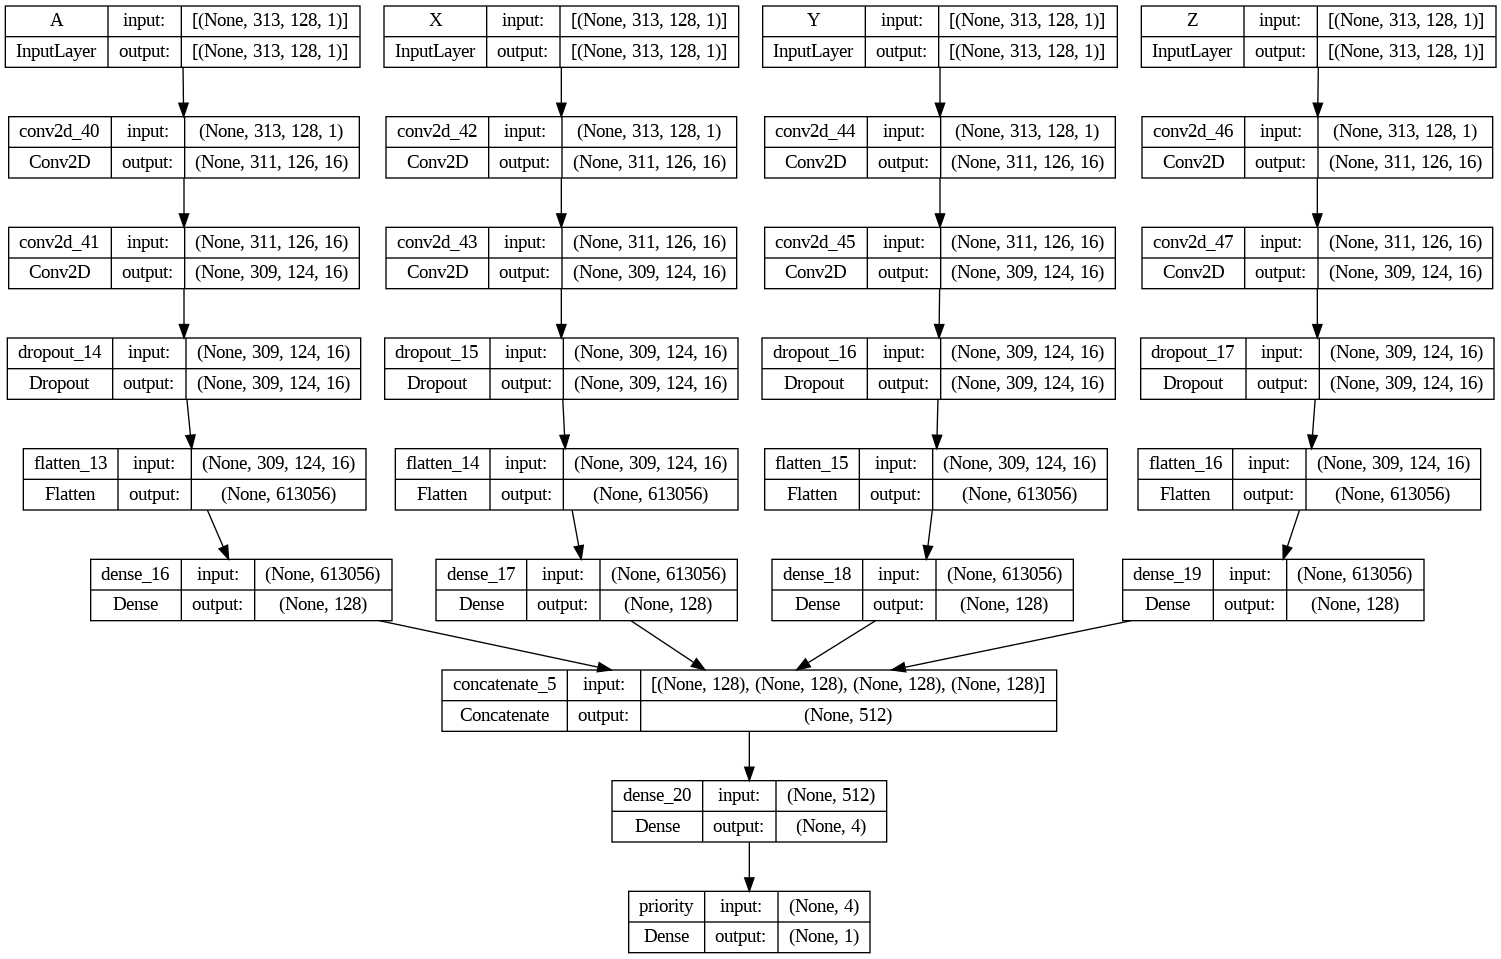

In [ ]:
keras.utils.plot_model(modelt, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
combined = concatenate([modelA.output, modelX.output, modelY.output, modelZ.output])
final = Dense(4, activation="relu")(combined)
final = Dense(1, activation="linear")(final)

In [ ]:
print(modelA.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 313, 128, 1), dtype=tf.float32, name='conv2d_11_input'), name='conv2d_11_input', description="created by layer 'conv2d_11_input'")


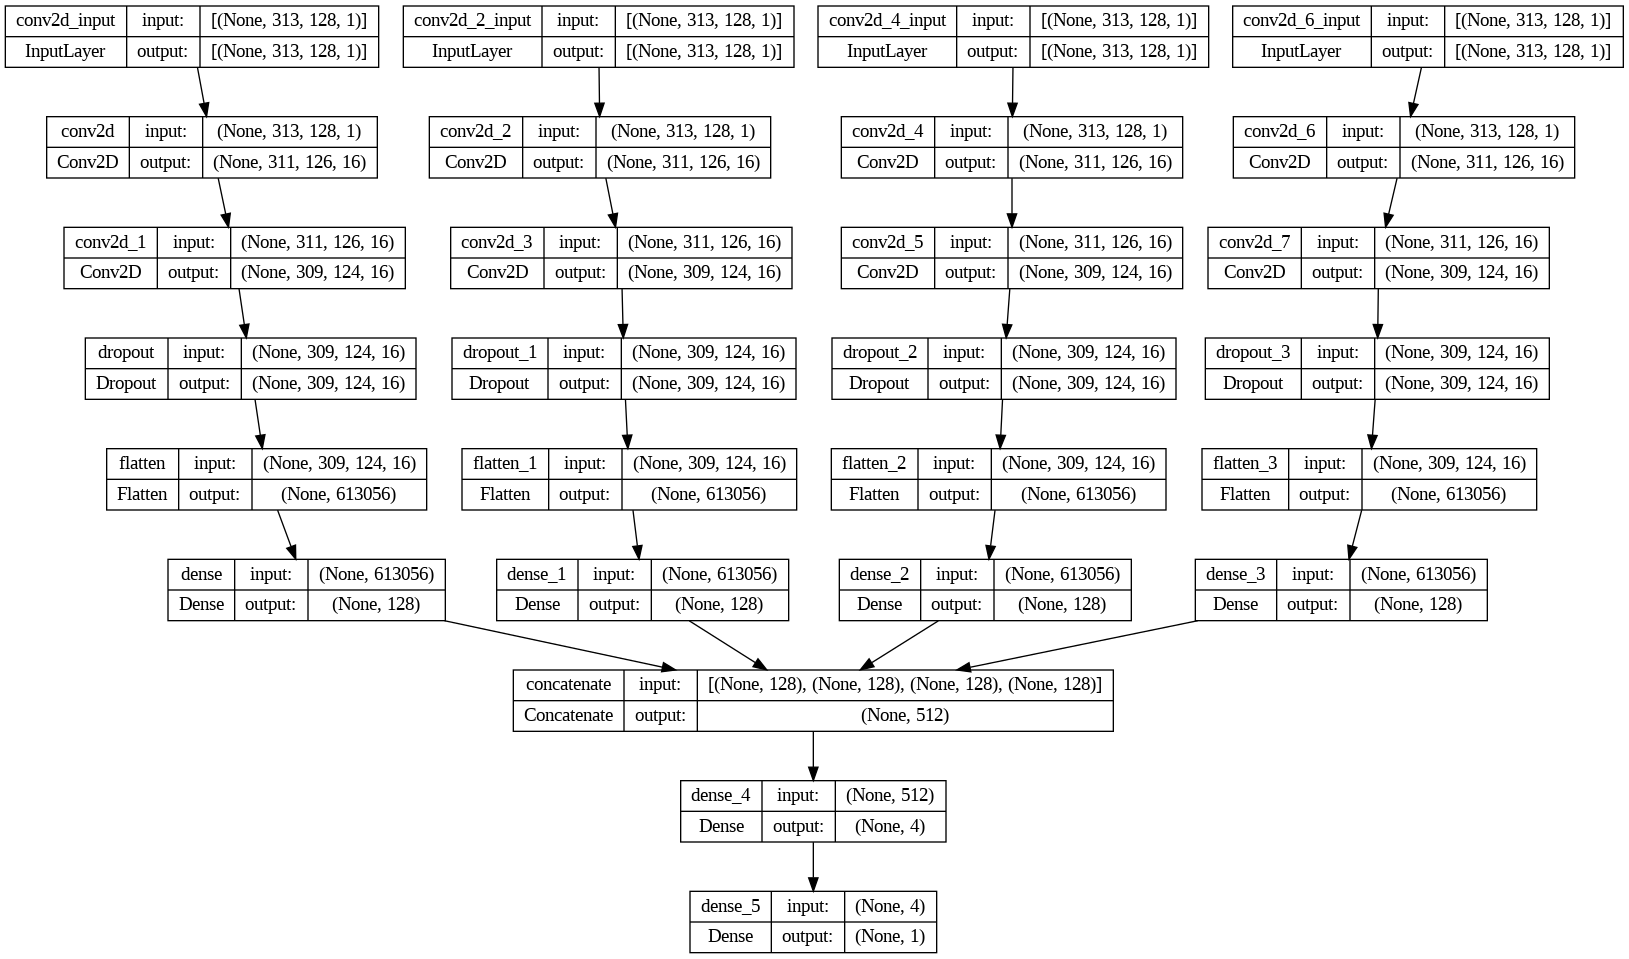

In [ ]:
model = Model(inputs=[modelA.input,modelX.input,modelY.input,modelZ.input],
              outputs=final)
opt = Adam(lr=1e-3)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)
#model.summary()
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
hist = model.fit([trainA, trainX, trainY, trainZ],
                 epochs=3,
                 validation_data=[testA, testX, testY, testZ])

ValueError: ignored

In [ ]:
samples, labels = trainA.as_numpy_iterator().next()
samples.shape

(16, 313, 128, 1)

In [ ]:
hist = model.fit(
    {"A": trainA, "X": trainX, "Y": trainY, "Z":trainZ},
    epochs=3,
    validation_data=[testA, testX, testY, testZ]
)

ValueError: ignored

In [ ]:
#https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/